In [1]:
import numpy as np
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from tensorflow import keras
import os



In [2]:



batch_size = 16
image_height = 512
image_width = 512


#
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "../deployment/DATA/Training",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (image_height,image_width),
    batch_size = (batch_size)
)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "../deployment/DATA/Training/",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (image_height,image_width),
    batch_size = (batch_size)
)   
val_images = []
val_labels = []

for images , labels in validation_dataset:
    val_images.append(images)
    val_labels.append(labels)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


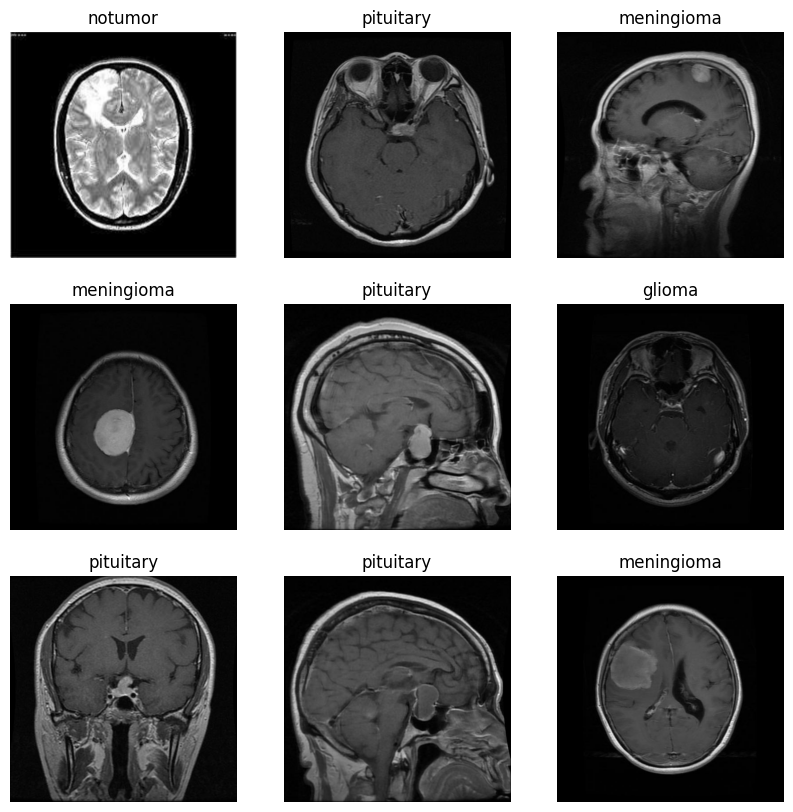

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 512, 512, 3)
(16,)


In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [7]:

AUTOTUNE = tf.data.AUTOTUNE

# Data Augmentation
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(12, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(24, 3, activation='relu'),  # Increased filter size
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(48, 3, activation='relu'),  # Increased filter size
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(48, 3, activation='relu'),  # Increased filter size
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),  # Added dropout layer
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dropout(0.3),  # Added dropout layer
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


# Learning Rate Scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.97,
    staircase=True)

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
model.build(input_shape=(None, 512, 512, 3))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 12)      336       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 12)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 24)      2616      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 24)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 48)      

In [8]:
class MetricsLogger(keras.callbacks.Callback):
    def __init__(self):
        super(MetricsLogger, self).__init__()
        self.batch_losses = []
        self.batch_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_accuracies.append(logs['accuracy'])


metrics = MetricsLogger()


In [10]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=2,
  callbacks=metrics
)

Epoch 1/2
286/286 [==============================] - 179s 625ms/step - loss: 0.2690 - accuracy: 0.8993 - val_loss: 0.3199 - val_accuracy: 0.8949
Epoch 2/2
286/286 [==============================] - 186s 648ms/step - loss: 0.1855 - accuracy: 0.9330 - val_loss: 0.3523 - val_accuracy: 0.8774


[]


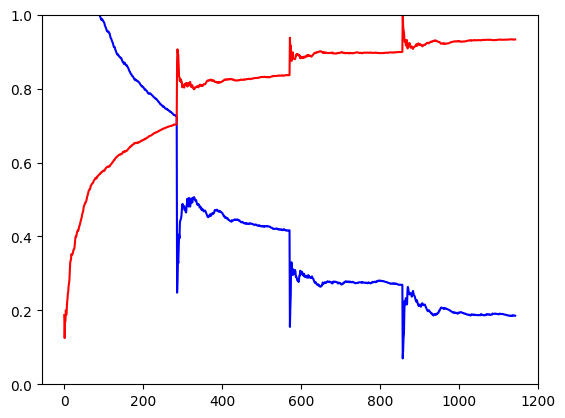

In [11]:
plt.plot(range(len(metrics.batch_losses)), metrics.batch_losses, label="loss", color="blue")
plt.plot(range(len(metrics.batch_accuracies)), metrics.batch_accuracies, label="accuracy", color="red")
plt.plot(range(len(metrics.val_losses)), metrics.val_losses, label="Valloss", color="lightblue")
plt.plot(range(len(metrics.val_accuracies)), metrics.val_accuracies, label="valaccuracy", color="pink")
plt.ylim(0,1)
print(metrics.val_losses)


In [15]:
model.evaluate(validation_dataset)

72/72 [==============================] - 9s 120ms/step - loss: 0.2765 - accuracy: 0.9116


[0.27651724219322205, 0.9115586876869202]

In [16]:
model.evaluate(train_dataset)

286/286 [==============================] - 77s 270ms/step - loss: 0.0989 - accuracy: 0.9683


[0.09891386330127716, 0.9682713150978088]

In [17]:
tf.keras.models.save_models(
    model,
    "modelTumor.h5",
    include_optimizer = True,
    save_format="h5"
)